In [5]:
!pip install kaggle

In [6]:
!pip install kagglehub

In [7]:
import kagglehub

path = kagglehub.dataset_download("anasmohammedtahir/covidqu")
print(path)

Using Colab cache for faster access to the 'covidqu' dataset.
/kaggle/input/covidqu


In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Extra safety check
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: Tesla T4


In [9]:
BASE_DIR = "/kaggle/input/covidqu/Infection Segmentation Data/Infection Segmentation Data"

TRAIN_DIR = os.path.join(BASE_DIR, "Train")
VAL_DIR   = os.path.join(BASE_DIR, "Val")
TEST_DIR  = os.path.join(BASE_DIR, "Test")

CLASSES = ["COVID-19", "Non-COVID", "Normal"]

Train: {'COVID-19': 1864, 'Non-COVID': 932, 'Normal': 932}
Val: {'COVID-19': 466, 'Non-COVID': 233, 'Normal': 233}
Test: {'COVID-19': 583, 'Non-COVID': 292, 'Normal': 291}


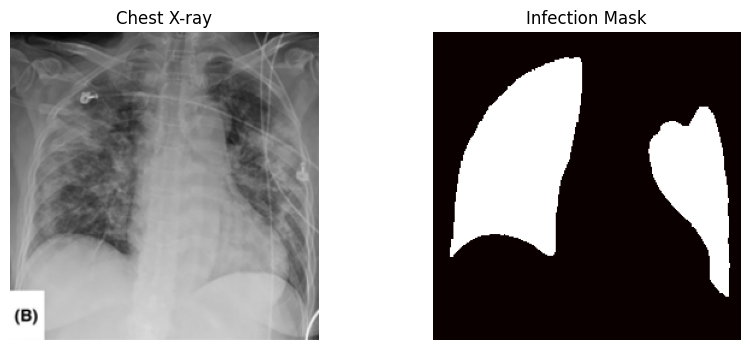

In [10]:
def count_images(split_dir):
    counts = {}
    for cls in CLASSES:
        img_dir = os.path.join(split_dir, cls, "images")
        counts[cls] = len(os.listdir(img_dir))
    return counts

print("Train:", count_images(TRAIN_DIR))
print("Val:", count_images(VAL_DIR))
print("Test:", count_images(TEST_DIR))

cls = "COVID-19"
img_path = os.path.join(TRAIN_DIR, cls, "images")
mask_path = os.path.join(TRAIN_DIR, cls, "infection masks")

img_name = os.listdir(img_path)[0]

image = cv2.imread(os.path.join(img_path, img_name), cv2.IMREAD_GRAYSCALE)
mask  = cv2.imread(os.path.join(mask_path, img_name), cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image, cmap="gray")
plt.title("Chest X-ray")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask, cmap="hot")
plt.title("Infection Mask")
plt.axis("off")
plt.show()

In [11]:
class COVIDSegDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for cls in CLASSES:
            img_dir = os.path.join(root_dir, cls, "images")
            mask_dir = os.path.join(root_dir, cls, "infection masks")

            for fname in os.listdir(img_dir):
                self.samples.append((
                    os.path.join(img_dir, fname),
                    os.path.join(mask_dir, fname)
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (256,256))
        mask  = cv2.resize(mask, (256,256))

        image = image / 255.0
        mask  = mask / 255.0

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        mask  = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask

In [12]:
train_dataset = COVIDSegDataset(TRAIN_DIR)
val_dataset   = COVIDSegDataset(VAL_DIR)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))

Train samples: 3728
Val samples: 932


In [13]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU()
            )

        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = CBR(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = CBR(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = CBR(128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up3(b), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.out(d1))

In [16]:
model = UNet().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def dice_coef(pred, target, smooth=1e-6):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [17]:
num_epochs = 15
train_loss_hist = []
val_loss_hist = []
dice_hist = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks  = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_hist.append(train_loss)

    model.eval()
    val_loss = 0
    dice_score = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks  = masks.to(device)
            outputs = model(images)

            val_loss += criterion(outputs, masks).item()
            dice_score += dice_coef(outputs, masks).item()

    val_loss /= len(val_loader)
    dice_score /= len(val_loader)

    val_loss_hist.append(val_loss)
    dice_hist.append(dice_score)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Dice: {dice_score:.4f}")

Epoch [1/15] Train Loss: 0.3219 | Val Loss: 0.2178 | Dice: 0.5000
Epoch [2/15] Train Loss: 0.2165 | Val Loss: 0.1961 | Dice: 0.5000
Epoch [3/15] Train Loss: 0.2005 | Val Loss: 0.1878 | Dice: 0.5000
Epoch [4/15] Train Loss: 0.1950 | Val Loss: 0.1805 | Dice: 0.5000
Epoch [5/15] Train Loss: 0.1862 | Val Loss: 0.1704 | Dice: 0.5000
Epoch [6/15] Train Loss: 0.1747 | Val Loss: 0.1679 | Dice: 0.5000
Epoch [7/15] Train Loss: 0.1652 | Val Loss: 0.1478 | Dice: 0.2016
Epoch [8/15] Train Loss: 0.1557 | Val Loss: 0.1537 | Dice: 0.0427
Epoch [9/15] Train Loss: 0.1507 | Val Loss: 0.1442 | Dice: 0.2182
Epoch [10/15] Train Loss: 0.1437 | Val Loss: 0.1326 | Dice: 0.2585
Epoch [11/15] Train Loss: 0.1379 | Val Loss: 0.1367 | Dice: 0.1868
Epoch [12/15] Train Loss: 0.1337 | Val Loss: 0.1321 | Dice: 0.1912
Epoch [13/15] Train Loss: 0.1288 | Val Loss: 0.1243 | Dice: 0.2430
Epoch [14/15] Train Loss: 0.1256 | Val Loss: 0.1230 | Dice: 0.3109
Epoch [15/15] Train Loss: 0.1213 | Val Loss: 0.1134 | Dice: 0.3338


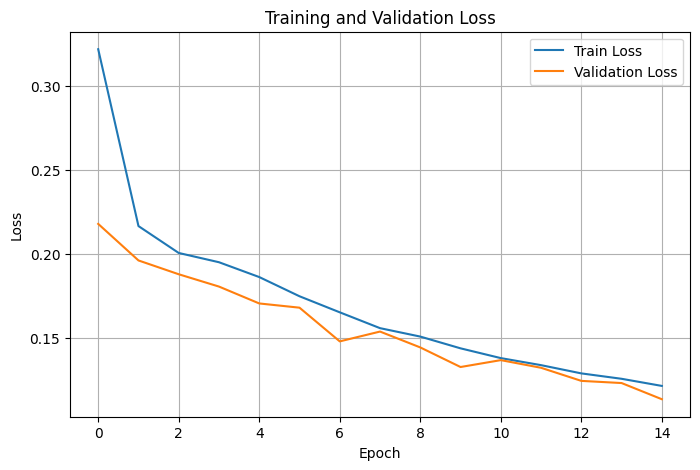

In [18]:
plt.figure(figsize=(8,5))
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("output1.png", dpi=300)
plt.show()

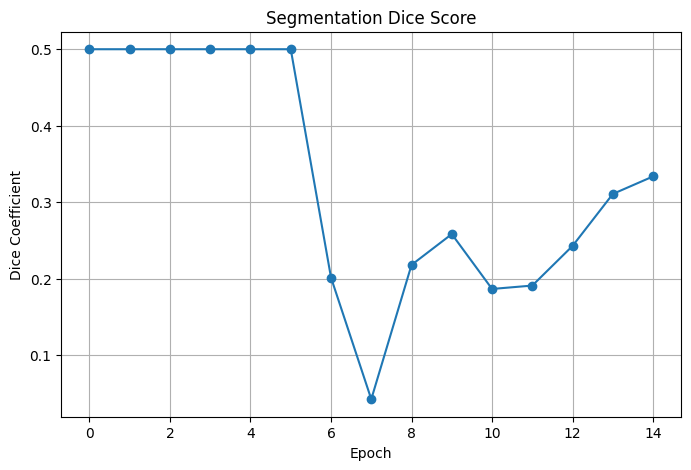

In [19]:
plt.figure(figsize=(8,5))
plt.plot(dice_hist, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient")
plt.title("Segmentation Dice Score")
plt.grid(True)
plt.savefig("output2.png", dpi=300)
plt.show()

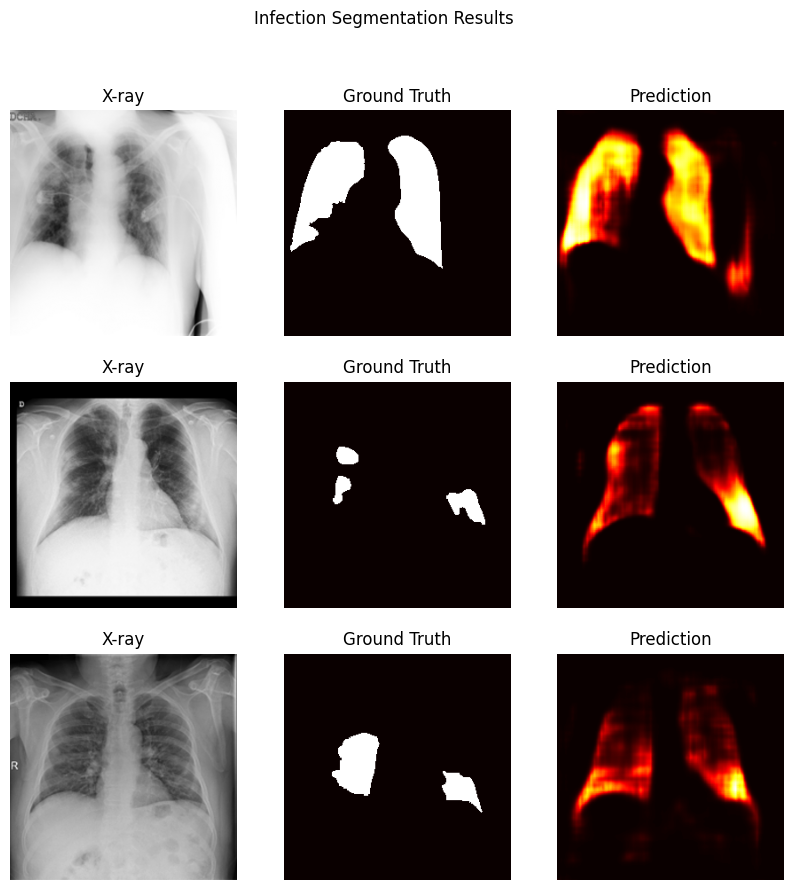

In [20]:
model.eval()
images, masks = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    preds = model(images)

fig, axes = plt.subplots(3, 3, figsize=(10,10))

for i in range(3):
    axes[i,0].imshow(images[i][0].cpu(), cmap="gray")
    axes[i,0].set_title("X-ray")

    axes[i,1].imshow(masks[i][0], cmap="hot")
    axes[i,1].set_title("Ground Truth")

    axes[i,2].imshow(preds[i][0].cpu(), cmap="hot")
    axes[i,2].set_title("Prediction")

    for j in range(3):
        axes[i,j].axis("off")

plt.suptitle("Infection Segmentation Results")
plt.savefig("output3.png", dpi=300)
plt.show()

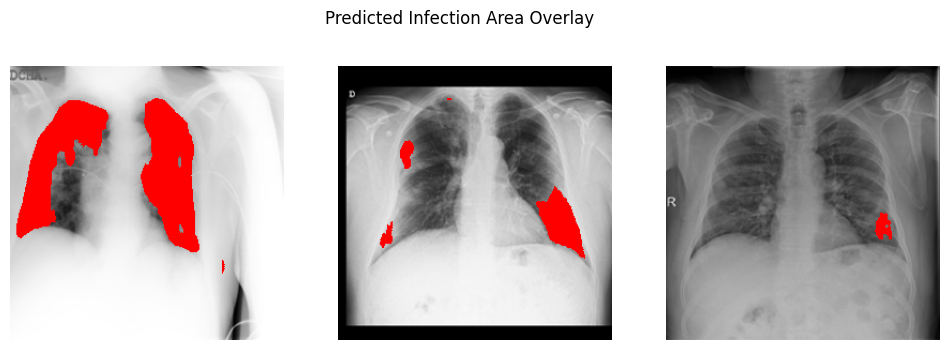

In [21]:
def overlay(image, mask):
    color = np.stack([image, image, image], axis=-1)
    color[mask > 0.5] = [1, 0, 0]
    return color

plt.figure(figsize=(12,4))
for i in range(3):
    overlay_img = overlay(images[i][0].cpu().numpy(),
                          preds[i][0].cpu().numpy())
    plt.subplot(1,3,i+1)
    plt.imshow(overlay_img)
    plt.axis("off")

plt.suptitle("Predicted Infection Area Overlay")
plt.savefig("output4.png", dpi=300)
plt.show()